# FAIRICUBE Machine Learning UDF Proof of Concept

This proof of concept (PoC) demonstrates how to execute a semantic segmentation machine learning ML prediction in
[rasdaman](https://doc.rasdaman.org/) using rasql, user-defined functions UDFs, and the ML library 
[libtorch](https://pytorch.org/cppdocs/).

## Description

The PoC consists of classifying the per pixel crop label from a preprocessed 28-band sentinel 2 stacked (seasonal) image of a study area of the Netherlands.

### Inputs 

1. **sentinel2_image:** [subset] of preprocessed sentinel2 image (ingested to rasdaman)
2. **maxes_sentinel2_image:**: Per band maxes of the whole sentinel2 image (ingested to rasdaman)

Example sentinel2_image:
![Input 28 band sentinel 2 image](input_sentinel2.png)

Example maxes_sentinel2_image:

**18803,17742,16911,16096,19135,17927,17077,16199,17477,16813,16203,15558,18048,16736,16152,15568,17712,16752,16144,15529,17632,16704,16112,15544,17904,16928,16272,15672**

### Output 

2D array of integers (0-67) representing the per pixel label of the crop.

Example 2D integer representation csv:
[[14,14,14,14,14,14,14,14,14],
  [14,14,14,14,14,14,14,14,14],
  [14,14,14,14,14,14,14,14,14],
  [14,14,14,14,14,14,14,14,14],
  [14,14,14,14,14,14,14,14,14],
  [14,14,14,14,14,14,14,14,23],
  [14,14,14,14,14,9,14,23,23],
  [14,14,14,14,14,3,23,23,23],
  [14,14,14,14,23,3,3,23,23]
  ]

Visual representation:
![Output of the Per Pixel Prediction as PNG](output_prediction.png)

### Preparations

First, we import all required packages and initialize the Rasdaman query instance (see query_utils.py).
The latter allows us to submit query-strings (according to the format of the WCPS-service) and tracks some key parameters of the submitted queries, the time for retrieving the data as well as the downloaded data amount in MB.

In [48]:
# Import packages.
from IPython.display import Image
import os, sys
sys.path.append(os.getcwd())
import datetime as dt
import numpy as np
from PIL import Image
import io
import requests
import csv
import query_utils

# Get query-instance for rasdaman
Rasdaman_Query = query_utils.Rasdaman_Query

rq = Rasdaman_Query()

%check_endpoint: Selected service endpoint 'http://fairicube.rasdaman.com:8080/rasdaman/ows#/services' reached successfully.


The following parameters are reused in the queries in the following.

In [49]:
coverage = "sentinel2_2018_flevopolder_10m_7x4bands"
maxes_coverage = "maxes_sentinel2_2018_flevopolder_10m_7x4bands"

# Credentials
username = os.environ.get('RAS_USER')
password = os.environ.get('RAS_PASSWD')
credentials = requests.auth.HTTPBasicAuth(username, password)

### rasdaman UDF interface

### WCPS UDF
The following example retrieves a {enter_size_here} semantically segmented png image using WCPS.

The query is...
 
for $sentinel2 in ( sentinel2_2018_flevopolder_10m_7x4bands ),
    $maxes in ( maxes_sentinel2_2018_flevopolder_10m_7x4bands )
let $s2_cutout := $sentinel2[E(677400:679900),N(5834260:5836760)]
return 
	encode( fairicube.predictCropClass(
                $s2_cutout,
                $maxes),
            "png" )

%get_query: Start query...
%get_query: Data query took  0.82 seconds.


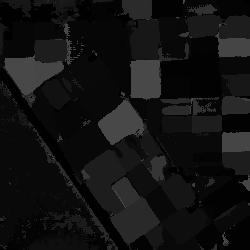

In [50]:
query = """
for $sentinel2 in ( {0} ),
    $maxes in ( {1} )
let $s2_cutout := $sentinel2[E(677400:679900),N(5834260:5836760)]
return 
	encode( fairicube.predictCropClass(
                $s2_cutout,
                $maxes),
            "png" )
""".format(coverage, maxes_coverage, cutout)
params = { "query" : query }

# submit the query...
response = rq.get_query(query, credentials=credentials)

# display the result
img = Image.open(response)
display(img)

#### What else can be done?

rasdaman provides a wide range of feature that can be used to further process the result of the prediction. For example...

##### Crop Classification Coloring

The query is...
 
for $sentinel2 in ( sentinel2_2018_flevopolder_10m_7x4bands ),
    $maxes in ( maxes_sentinel2_2018_flevopolder_10m_7x4bands )
let $s2_cutout := $sentinel2[E(677400:679900),N(5834260:5836760)],
    $result := fairicube.predictCropClass($s2_cutout, $maxes)
return 
    encode( switch
             case $result = 0
              return {red: 255; green: 255; blue: 255}
             case 20 > $result
              return {red: 0; green: 0; blue: 255}
             case 40 > $result
              return {red: 255; green: 255; blue: 0}
             case 60 > $result
              return {red: 255; green: 140; blue: 0}
             default return {red: 255; green: 0; blue: 0},
            "png" )

%get_query: Start query...
%get_query: Data query took  2.92 seconds.


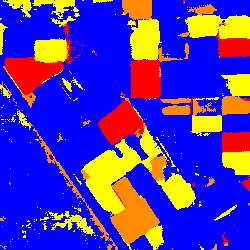

In [51]:
query = """
for $sentinel2 in ( sentinel2_2018_flevopolder_10m_7x4bands ),
    $maxes in ( maxes_sentinel2_2018_flevopolder_10m_7x4bands )
let $s2_cutout := $sentinel2[E(677400:679900),N(5834260:5836760)],
    $result := fairicube.predictCropClass($s2_cutout, $maxes)
return 
    encode( switch
             case $result = 0
              return {red: 255; green: 255; blue: 255}
             case 20 > $result
              return {red: 0; green: 0; blue: 255}
             case 40 > $result
              return {red: 255; green: 255; blue: 0}
             case 60 > $result
              return {red: 255; green: 140; blue: 0}
             default return {red: 255; green: 0; blue: 0},
            "png" )
"""
params = { "query" : query }

# submit the query...
response = rq.get_query(query, credentials=credentials)

# display the result
img = Image.open(response)
display(img)

### rasql UDF

In [43]:
!sed -n 24,76p ./rasql_udf/2_test_udf.sh

#
# SYNOPSIS
# ./2_test_udf.sh
#
# Description
#  Command-line utility for testing the prediction UDF "fairicube.predictCropClass".
#  It tests three examples. Each example takes a cutout of the coverage 
#  sentinel2_2018_flevopolder_10m_7x4bands and outputs a JSON file with
#  pixel crop classification prediction. The cutouts are as follows:
#  1. 9x9 cutout example
#  2. 250x250 cutout example
#  3. 250x250 cutout example
#  The prediction UDF takes a cutout of the sentinel2_2018_flevopolder_10m_7x4bands 
#  coverage and outputs the crop labels per pixel of that cutout.
#
# PRECONDITIONS
#  1) rasdaman must be running
#  2) fairicube.predictCropClass UDF must be present in rasdaman

RASQL="/opt/rasdaman/bin/rasql --user $RAS_USER --passwd $RAS_PASSWD"

############################
# 9x9 cutout example to json
############################
$RASQL -q 'select encode (fairicube.predictCropClass(s2_cutout[250:258,200:208], maxes), "json") from sentinel2_2018_flevopolder_10m_7x4bands as s2

In [14]:
!./rasql_udf/2_test_udf.sh

/opt/rasdaman/bin/rasql: rasdaman query tool 10.2.2.
Opening database RASBASE at 127.0.0.1:7001... ok.
Executing retrieval query... ok.
Query result collection has 1 element(s):
  Result object 1: going into file prediction_9x9.json... ok.
/opt/rasdaman/bin/rasql done.
/opt/rasdaman/bin/rasql: rasdaman query tool 10.2.2.
Opening database RASBASE at 127.0.0.1:7001... ok.
Executing retrieval query... ok.
Query result collection has 1 element(s):
  Result object 1: going into file prediction_250x250.png... ok.
/opt/rasdaman/bin/rasql done.
/opt/rasdaman/bin/rasql: rasdaman query tool 10.2.2.
Opening database RASBASE at 127.0.0.1:7001... ok.
Executing retrieval query... ok.
Query result collection has 1 element(s):
  Result object 1: going into file prediction_full.tif... ok.
/opt/rasdaman/bin/rasql done.


9x9 result

 diagram>>
for $sentinel2 in ( sentinel2_2018_flevopolder_10m_7x4bands ),
    $maxes in ( maxes_sentinel2_2018_flevopolder_10m_7x4bands )
let $s2_cutout := $sentinel2[E(677400:679900),N(5834260:5836760)],
    $result := fairicube.predictCropClass($s2_cutout, $maxes)
return 
    encode( coverage histogram over $bucket x(0:67)
            values count ( $result = $bucket ),
           "text/csv" ) 